# Введение в искусственные нейронные сети

# Урок 5. Рекуррентные нейронные сети

# <font color='blue'>Практическое задание</font>

<ol>
    <li>Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

    
<li>*Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM</li>
<li>*Предложите свои варианты решения проблемы исчезающего градиента в RNN</li>
</ol>

In [426]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [427]:
from google.colab import files
import os
import datetime

In [428]:
numpy.random.seed(7)

Читаем данные из файла со значениями (набор airline-passengers - пасажиропоток для авиалиний)

In [429]:
files.upload()
!ls

Saving airline-passengers.csv to airline-passengers (5).csv
'airline-passengers (1).csv'  'airline-passengers (4).csv'   logs2
'airline-passengers (2).csv'  'airline-passengers (5).csv'   sample_data
'airline-passengers (3).csv'   airline-passengers.csv


In [430]:
dataframe = pd.read_csv('/content/airline-passengers.csv', usecols=[1], engine='python')

In [431]:
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [432]:
type(dataframe)

pandas.core.frame.DataFrame

In [433]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 1.2 KB


In [434]:
dataframe.columns

Index(['Passengers'], dtype='object')

In [435]:
dataframe.shape

(144, 1)

In [436]:
dataframe.isnull().sum()

Passengers    0
dtype: int64

### Данные о пасажиропотоке + индексы (Month)

In [437]:
dataframe.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


In [438]:
# dataframe.sort_index(ascending=True, inplace=True)
# dataframe.head()

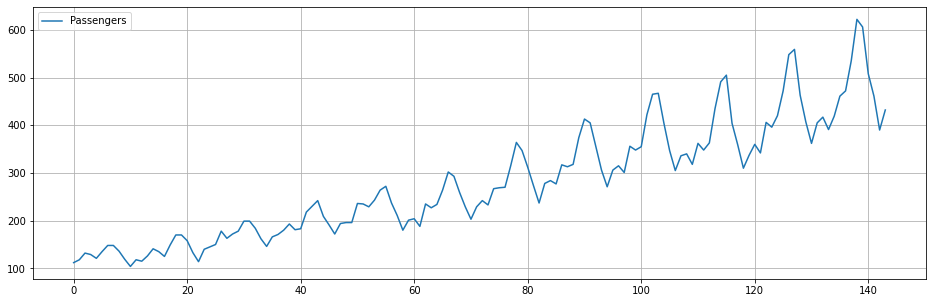

In [439]:
dataframe.plot( figsize = (16,5))
# df['Passengers'].plot( figsize = (16,5))

plt.grid('On')
plt.show()

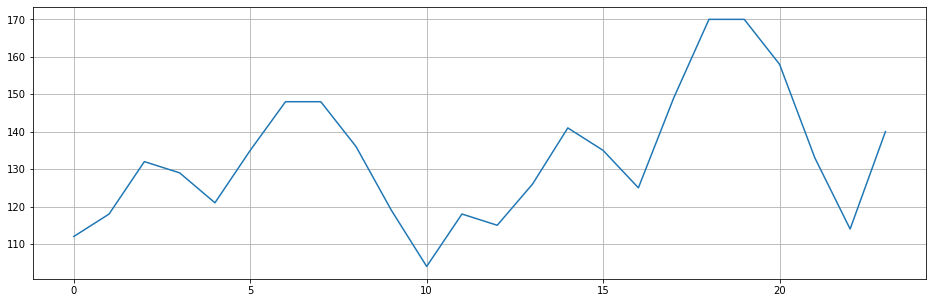

In [440]:
# dataframe['Passengers'][130:144].plot( figsize = (16,5))
dataframe['Passengers'][0:24].plot( figsize = (16,5))

plt.grid('On')
plt.show()


__В данных отчётливо наблюдаются__:
- тренд;
- периодичность (очевидно связанная с сезонностью);
- увеличение амплитуды колебаний пасажиропотока со временем.

In [441]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


<!-- Добавим месяц как признаки: как "месяц в году"/12 и (год-1949) -->

In [442]:
print(dataframe.shape)

(144, 1)


## Создаем данные для обучения

In [443]:
def create_dataset(dataset, look_back=1):
  # разбиваем датасет на обучающую и тестовую выборки
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

Выделяем части на обучение и проверку (у нас временной ряд)

In [444]:
train_size = int(len(dataset) * 0.67)  # длина прошлого
test_size = len(dataset) - train_size  # длина тестового периода
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [445]:
look_back = 3

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [446]:
print(type(trainX))
trainX[:3]

<class 'numpy.ndarray'>


array([[0.01544401, 0.02702703, 0.05405405],
       [0.02702703, 0.05405405, 0.04826255],
       [0.05405405, 0.04826255, 0.03281853]], dtype=float32)

In [447]:
print(type(trainY))
print(len(trainY))
trainY

<class 'numpy.ndarray'>
92


array([0.04826255, 0.03281853, 0.05984557, 0.08494207, 0.08494207,
       0.06177607, 0.02895753, 0.        , 0.02702703, 0.02123553,
       0.04247104, 0.07142857, 0.05984557, 0.04054055, 0.08687258,
       0.12741312, 0.12741312, 0.10424709, 0.05598456, 0.01930502,
       0.06949806, 0.07915059, 0.08880308, 0.14285713, 0.11389962,
       0.13127413, 0.14285713, 0.18339768, 0.18339768, 0.15444016,
       0.11196911, 0.08108109, 0.1196911 , 0.12934363, 0.14671814,
       0.17181468, 0.14864865, 0.15250966, 0.22007722, 0.24324325,
       0.26640925, 0.2027027 , 0.16795367, 0.13127413, 0.17374519,
       0.17760617, 0.17760617, 0.25482625, 0.25289574, 0.24131274,
       0.26833975, 0.3088803 , 0.32432434, 0.25675675, 0.20656371,
       0.14671814, 0.18725869, 0.19305018, 0.16216215, 0.25289574,
       0.23745173, 0.25096524, 0.3088803 , 0.38223937, 0.36486486,
       0.2992278 , 0.24131274, 0.1911197 , 0.24131274, 0.26640925,
       0.24903473, 0.31467178, 0.3185328 , 0.32046333, 0.40733

In [448]:
print(type(testX))
testX[:3]

<class 'numpy.ndarray'>


array([[0.4073359 , 0.3803089 , 0.48648646],
       [0.3803089 , 0.48648646, 0.47104248],
       [0.48648646, 0.47104248, 0.484556  ]], dtype=float32)

In [449]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [450]:
print(type(trainX))
print(len(trainX))
trainX[:3]

<class 'numpy.ndarray'>
92


array([[[0.01544401],
        [0.02702703],
        [0.05405405]],

       [[0.02702703],
        [0.05405405],
        [0.04826255]],

       [[0.05405405],
        [0.04826255],
        [0.03281853]]], dtype=float32)

In [451]:
print(type(testX))
print(len(testX))
testX[:3]

<class 'numpy.ndarray'>
44


array([[[0.4073359 ],
        [0.3803089 ],
        [0.48648646]],

       [[0.3803089 ],
        [0.48648646],
        [0.47104248]],

       [[0.48648646],
        [0.47104248],
        [0.484556  ]]], dtype=float32)

Посмотрим на данные для тренировки и теста

In [452]:
data = dataframe.copy()

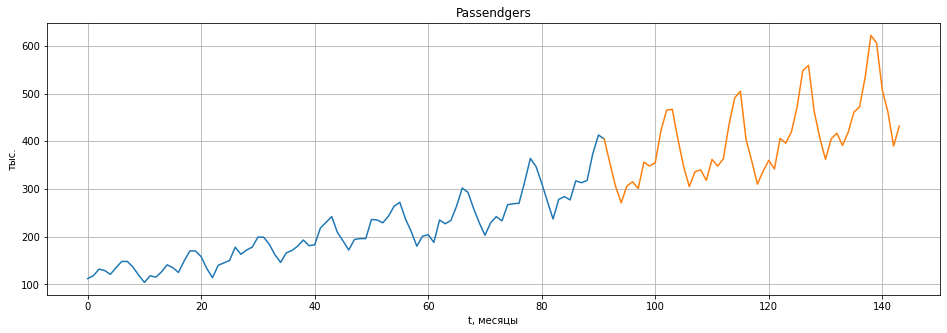

In [453]:
plt.figure(figsize=(16,5))
# plt.plot(data.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data.index[0:92],data[0:92])
plt.plot(data.index[91:144],data[91:144])
plt.grid('on')
plt.xlabel('t, месяцы')
plt.ylabel('тыс.')
#plt.title('Пассажиропоток в 1949-1969')
plt.title('Passendgers')
plt.show()

Строим сеть

In [454]:
batch_size = 1

model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [455]:
# Обучаем
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()

92/92 - 2s - loss: 0.0065 - 2s/epoch - 19ms/step
92/92 - 0s - loss: 0.0135 - 157ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0080 - 156ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0059 - 201ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0051 - 190ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0047 - 176ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0045 - 171ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0044 - 174ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0043 - 166ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0043 - 167ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0042 - 181ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0042 - 161ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0042 - 170ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0041 - 177ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0041 - 178ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0040 - 174ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0040 - 170ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0040 - 161ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0039 - 183ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0039 - 164ms

In [456]:
# Делаем предсказание на train
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
# Делаем предсказание на test
testPredict = model.predict(testX, batch_size=batch_size)

In [457]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [458]:
# Значение метрики на train и test
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 24.92 RMSE
Test Score: 51.44 RMSE


In [459]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [460]:
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

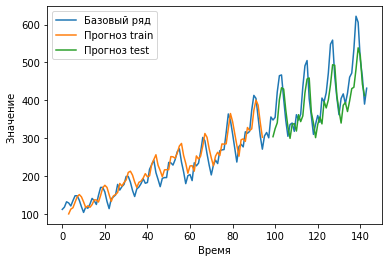

In [461]:

# Отобразим на графике данные и предсказания

plt.plot(scaler.inverse_transform(dataset), 
         label='Базовый ряд')
plt.plot(trainPredictPlot, 
         label='Прогноз train')
plt.plot(testPredictPlot,
         label='Прогноз test')

plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

In [486]:
look_back = 3

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


batch_size = 1

model1 = Sequential()
model1.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))

model.add(Flatten())                          # (None, n_Dense*n_lstm)
model.add(Dense(8, activation="linear"))      # (None,n_Dense)

model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')

# Обучаем
for i in range(100):
	model1.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model1.reset_states()

92/92 - 2s - loss: 0.0064 - 2s/epoch - 18ms/step
92/92 - 0s - loss: 0.0221 - 180ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0131 - 178ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0081 - 171ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0056 - 188ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0052 - 190ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0052 - 208ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0051 - 178ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0051 - 172ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0051 - 178ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0050 - 169ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0050 - 180ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0050 - 185ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0050 - 186ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0049 - 171ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0049 - 172ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0049 - 179ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0049 - 159ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0048 - 165ms/epoch - 2ms/step
92/92 - 0s - loss: 0.0048 - 167ms

In [487]:
# Делаем предсказание на train
trainPredict = model1.predict(trainX, batch_size=batch_size)
model.reset_states()
# Делаем предсказание на test
testPredict = model1.predict(testX, batch_size=batch_size)

In [488]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [489]:
# Значение метрики на train и test
print('Модель 1')
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

print('Модель 2')
trainScore1 = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore1))
testScore1 = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore1))

Модель 1
Train Score: 24.92 RMSE
Test Score: 51.44 RMSE
Модель 2
Train Score: 28.89 RMSE
Test Score: 62.51 RMSE


In [490]:
trainPredictPlot1 = numpy.empty_like(dataset)
trainPredictPlot1[:, :] = numpy.nan
trainPredictPlot1[look_back:len(trainPredict)+look_back, :] = trainPredict

In [491]:
testPredictPlot1 = numpy.empty_like(dataset)
testPredictPlot1[:, :] = numpy.nan
testPredictPlot1[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

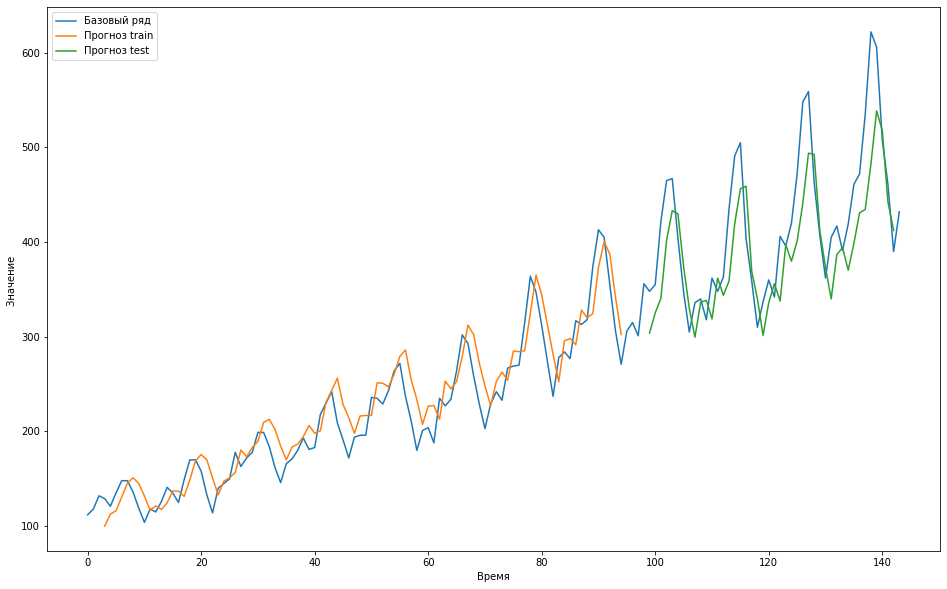

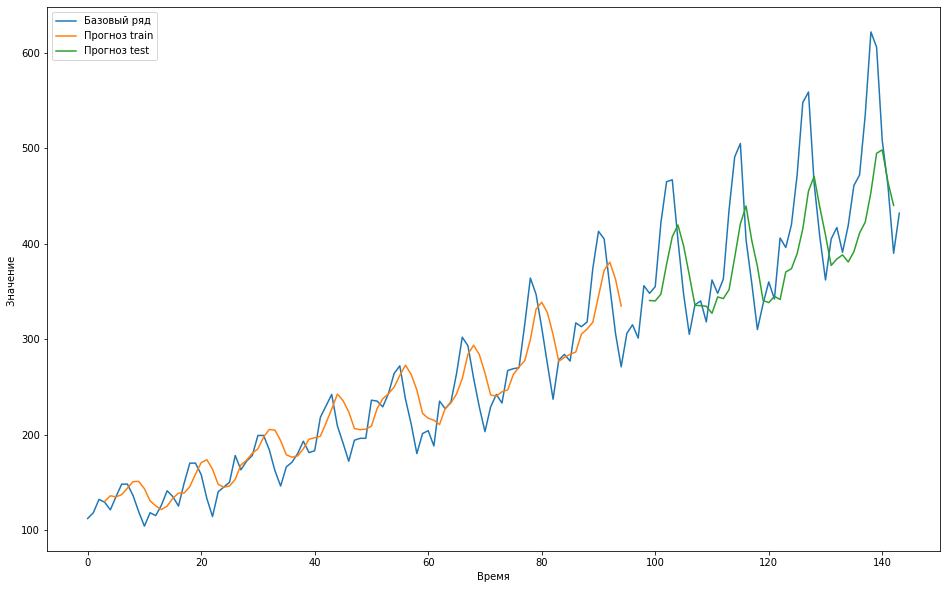

In [492]:
plt.figure(figsize=(16,10))

# Отобразим на графике данные и предсказания (1-я млдель)

plt.plot(scaler.inverse_transform(dataset), 
         label='Базовый ряд')
plt.plot(trainPredictPlot, 
         label='Прогноз train')
plt.plot(testPredictPlot,
         label='Прогноз test')

plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()
plt.figure(figsize=(16,10))
# Отобразим на графике данные и предсказания (2-я млдель)

plt.plot(scaler.inverse_transform(dataset), 
         label='Базовый ряд')
plt.plot(trainPredictPlot1, 
         label='Прогноз train')
plt.plot(testPredictPlot1,
         label='Прогноз test')

plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

Добавление 2-х слоёв Flatten и Dense в модель, позволило улучшить показатели модели.<br>
Модель 1<br>
Train Score: 24.92 RMSE<br>
Test Score: 51.44 RMSE<br>
Модель 2<br>
Train Score: 28.89 RMSE<br>
Test Score: 62.51 RMSE